<a href="https://colab.research.google.com/github/kumaramardeep342/Colab-Work/blob/main/Ed_AI__DL_M12_Covid_19_Cases_RNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount the Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

#enable table format
from google.colab import data_table
data_table.enable_dataframe_formatter()

#disable table format
# from google.colab import data_table
# data_table.disable_dataframe_formatter()

# Prediction Covid-19 Cases - RNN GRU

## Summary
- Problem Statement
- Load the Dataset
- About the Dataset
- Import the required libraries
- Pre-process the dataset

## Problem Statement
- Given a dataset that has data of cases related to the spread of Covid-19 virus in India.  
- Design RNN and GRU Model using Series Data.
- Use Covid-19 data to predict the number of future cases based on the available historical data.

## Load the Dataset

In [2]:
! pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/imdevskp/covid19-corona-virus-india-dataset')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sjagkoo7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/imdevskp/covid19-corona-virus-india-dataset


100%|██████████| 3.08M/3.08M [00:00<00:00, 125MB/s]

## About the Dataset
- Dataset folder having 116 Columns and 11 Files all.
- We will use complete.csv file , Having 10 Columns.
- Out of 10 columns will use 2 columns - Date & New Cases.

## Import the required libraries

In [3]:
# for data analysis
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator #Automatically chooses the best locator based on the date range.
#AutoDateLocator,DateLocator,YearLocator,MonthLocator,WeekdayLocator,DayLocator,HourLocator,MinuteLocator,SecondLocator,MicrosecondLocator,RRuleLocator
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler #feature scaling
from sklearn.model_selection import train_test_split #split train and test dataset

from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import GRU,Dense,Dropout

## Pre-process the dataset

In [4]:
complete_dataset = pd.read_csv('/content/covid19-corona-virus-india-dataset/complete.csv')
complete_dataset.head(2)

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0


In [5]:
complete_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4692 entries, 0 to 4691
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       4692 non-null   object 
 1   Name of State / UT         4692 non-null   object 
 2   Latitude                   4692 non-null   float64
 3   Longitude                  4692 non-null   float64
 4   Total Confirmed cases      4692 non-null   float64
 5   Death                      4692 non-null   object 
 6   Cured/Discharged/Migrated  4692 non-null   float64
 7   New cases                  4692 non-null   int64  
 8   New deaths                 4692 non-null   int64  
 9   New recovered              4692 non-null   int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 366.7+ KB


In [6]:
#Out of 10 columns will use 2 columns - Date & New Cases.
dataset_mini = complete_dataset[['Date','New cases']]
dataset_mini.head(2)

,Date,New cases
0,2020-01-30,0
1,2020-01-31,0


Text(0.5, 1.0, 'Trend of New Cases')

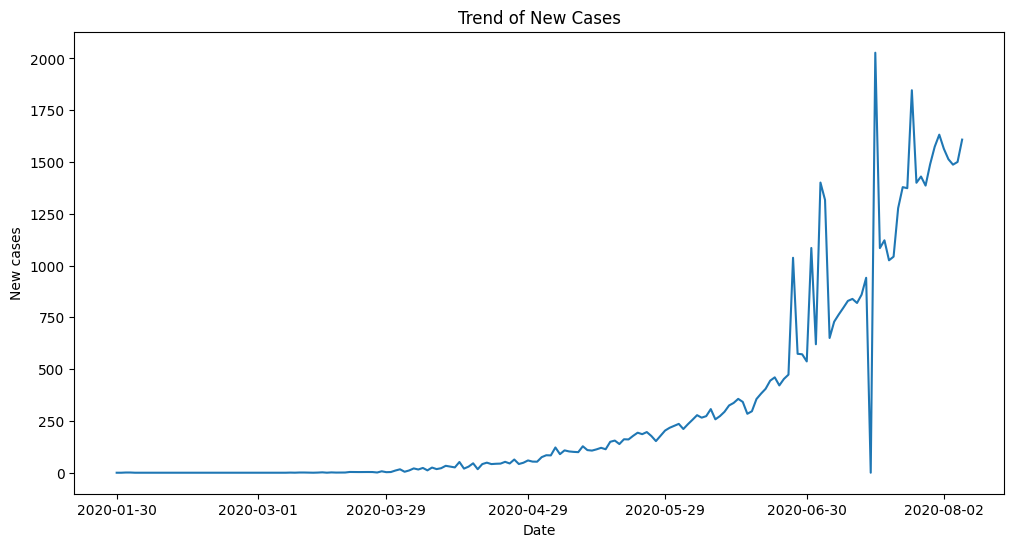

In [7]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))
# plotting trend
sns.lineplot(x='Date',y='New cases',data=dataset_mini,ax=ax,errorbar=None) # errorbar = None , seaborn not to draw the confidence interval.
#Automatically chooses the best locator based on the date range.
ax.xaxis.set_major_locator(AutoDateLocator())
#Setting the Title
ax.set_title('Trend of New Cases')

In [8]:
dataset = dataset_mini.copy()  #Create another dataset same as the main dataset. Just to avoid replacing the main one.
dataset = dataset.set_index('Date') #Set the index of the dataset as the date
dataset = dataset['New cases'] #We will be left with only one column Cases for our dataset
dataset.head(2)

,New cases
Date,
2020-01-30,0
2020-01-31,0


- To calculate the moving average either `rolling` method or `exapnding` method can be used.
- Example:
  > 1-Jan-2010   100

  > 2-Jan-2010   200

Moving average will be (200+100)/2 = 150

We will take moving average for 3 days in our example.


In [9]:
dataset = dataset.to_frame()  #Convert the Series into a dataframe object

In [10]:
# adding new feature Moving Average and  Exponential Moving Average(EMA)
dataset['Cases_MA2'] = dataset['New cases'].expanding(min_periods=3).mean() #min_periods is used to set the no. of periods for calculating MA. Mean is for calculating average.
dataset.head(5)

,New cases,Cases_MA2
Date,,
2020-01-30,0,NaN
2020-01-31,0,NaN
2020-02-01,1,0.333333
2020-02-02,1,0.500000
2020-02-03,0,0.400000


- Exponential Moving Average(EMA),We will take exponential moving average for 3 days in our example.

In [11]:
dataset['EMA'] = dataset.iloc[:,0].ewm(span=3,adjust=False).mean() #ewm is used exponential moving average
dataset.head(5)

,New cases,Cases_MA2,EMA
Date,,,
2020-01-30,0,NaN,0.000
2020-01-31,0,NaN,0.000
2020-02-01,1,0.333333,0.500
2020-02-02,1,0.500000,0.750
2020-02-03,0,0.400000,0.375


In [12]:
dataset = dataset[dataset['Cases_MA2'].notna()] #Remove the rows that have NAs
dataset.head(5)

,New cases,Cases_MA2,EMA
Date,,,
2020-02-01,1,0.333333,0.50000
2020-02-02,1,0.500000,0.75000
2020-02-03,0,0.400000,0.37500
2020-02-04,0,0.333333,0.18750
2020-02-05,0,0.285714,0.09375


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4690 entries, 2020-02-01 to 2020-08-06
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   New cases  4690 non-null   int64  
 1   Cases_MA2  4690 non-null   float64
 2   EMA        4690 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 146.6+ KB


In [14]:
#Cases is the column we have to predict.
target=dataset[['New cases']]
dataset.drop('New cases',axis=1,inplace=True)

<ipython-input-14-beea981a64c6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.drop('New cases',axis=1,inplace=True)


In [15]:
# x -> dataset with predictor variables
# y -> dataset with target variable
x, y = dataset.values, target.values

In [16]:
# feature scaling
x_scaled_set = MinMaxScaler() #Use MinMaxScaler function from sklearn.preprocessing library
y_scaled_set = MinMaxScaler()
X = x_scaled_set.fit_transform(x)
y = y_scaled_set.fit_transform(y.reshape(-1,1))

In [17]:
# split train and test dataset 80:20
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
X_train = X_train.reshape((-1,1,2)) #Reshape train dataset to required format
X_test = X_test.reshape((-1,1,2)) #Reshape test dataset to required format

# Build Model using RNN & Gated Recurrent Unit (GRU)

In [19]:
class Model:
  def __init__(self):
    self.GRU_model = None
  try :
      def build_model(self):
        self.GRU_model = Sequential() #Use Sequential function from keras.model library
        self.GRU_model.add(GRU(units=512,
                      return_sequences=True,
                      input_shape=(1, 2))) #Add GRU model with 512 units. Note that return sequences should be true to pass on the sequences. Ensure that input_shape is inline with the inout data.
        self.GRU_model.add(Dropout(0.2))  #Add a dropout layer to avoid overfitting.
        self.GRU_model.add(GRU(units=256)) #Add another GRU layer with 256 units.
        self.GRU_model.add(Dropout(0.2)) #Add another dropout layer to avoid overfitting.
        self.GRU_model.add(Dense(1, activation='sigmoid')) #Finally, add a dense layer for getting a fully connected layer.
        return self.GRU_model
  except Exception as e:
        print(f"An error occured : {str(e)}")

In [20]:
try :
  model = Model()
  GRU_model = model.build_model() #Build the model
  GRU_model.compile(loss='mse', optimizer='adam') #mse is mean square error which is the loss function and Adam optimizer will be the optimizer.
  GRU_model.summary() #model summary
except Exception as e:
         print(f"An error occured : {str(e)}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1, 512)              │         792,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 256)                 │         591,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,384,193 (5.28 MB)

 Trainable params: 1,384,193 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Dataset

In [21]:
GRU_model.fit(X_train,y_train,batch_size=250, epochs=30, validation_split=0.15, verbose=1)

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - loss: 0.1941 - val_loss: 0.0613
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.0359 - val_loss: 0.0068
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 0.0057 - val_loss: 0.0061
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 210ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - loss: 0.0052 - val_loss: 0.0061
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0056 - val_loss: 0.0061
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0046 - val_loss: 0.0061
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0052 - val_loss: 0.0061
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0051 - val_loss: 0.0061
Epoch 12/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - lo

## Predict

In [22]:
score = GRU_model.evaluate(X_test, y_test) #Evaluate model can be used to get the loss metric.
print('Score: {}'.format(score))
y_pred = GRU_model.predict(X_test) #Apply the built model on test data.
y_test_pred = y_scaled_set.inverse_transform(y_pred) #Use inverse transform to undo the scaling that was done before. This gives us the original values.
y_test_actual = y_scaled_set.inverse_transform(y_test) # Apply the inverse transform on the actual dataset for easy comparison of predicted vs actual.

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058
Score: 0.004680933430790901
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


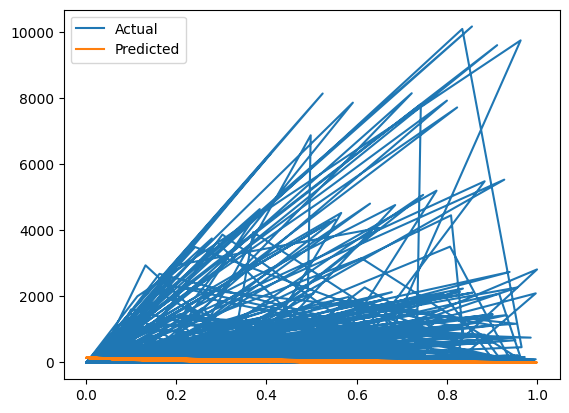

In [26]:
#Actual vs Predicted.

X_test_plot = X_test[:, 0, 0]  # Extract the first feature from X_test
plt.plot(X_test_plot,y_test_actual, label='Actual')
plt.plot(X_test_plot,y_test_pred ,label='Predicted')
plt.legend()
plt.show()
